<a href="https://colab.research.google.com/github/Mamidalarajesh/Facebook-sentiment-analytics/blob/main/FaceBook_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install facebook-sdk textblob

In [ ]:
import facebook
from textblob import TextBlob
import matplotlib.pyplot as plt

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ACCESS_TOKEN = "EAATfSyGlMkABO7T0O3Q6wNZAcxeEspdINZCiEfo3gtZAq2NtBGCk2F9pR4UnZAQD6DecyFD6uKvq44PBa0nvRMBDbtC1HivRZAx2TJeWjeMmOgdwWa0mqgCLKtHLzwm9oVZBZADeS1N7IRCVEMHIiL9q8RZA670v8AKwczDCZCtghnoZBP9WYDyHUKjKDPUHNFRd7LE9wNfSk1mrN9MqHZCVaV1A9APhOtpoZBIP5Q09nY6pJIZA8Adwo2LCsXTrl0FGPvwZDZD"

In [ ]:
graph = facebook.GraphAPI(access_token=ACCESS_TOKEN, version="3.1")

In [ ]:
def fetch_comments(post_id):
    """
    Fetch comments for a given Facebook post ID.
    """
    comments = []
    try:
        data = graph.get_object(id=post_id, fields='comments')
        comments_data = data['comments']['data']
        for comment in comments_data:
            comments.append(comment['message'])
    except facebook.GraphAPIError as e:
        print("Error:", e)
    return comments


In [ ]:
fetch_comments(2653017738191720)

Error: Unsupported get request. Object with ID '2653017738191720' does not exist, cannot be loaded due to missing permissions, or does not support this operation. Please read the Graph API documentation at https://developers.facebook.com/docs/graph-api


[]

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
fb = pd.read_csv('fb_sentiment.csv')

In [ ]:
fb.head()

,Unnamed: 0,FBPost,Label
0,0,Drug Runners and a U.S. Senator have somethin...,O
1,1,"Heres a single, to add, to Kindle. Just read t...",O
2,2,If you tire of Non-Fiction.. Check out http://...,O
3,3,Ghost of Round Island is supposedly nonfiction.,O
4,4,Why is Barnes and Nobles version of the Kindle...,N


In [ ]:
print(fb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   FBPost      1000 non-null   object
 2   Label       1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB
None


In [ ]:
fb.shape

(1000, 3)

In [ ]:
fb.notnull().sum()

Unnamed: 0    1000
FBPost        1000
Label         1000
dtype: int64

In [ ]:
fb.describe()

,Unnamed: 0
count,1000.000000
mean,499.500000
std,288.819436
min,0.000000
25%,249.750000
50%,499.500000
75%,749.250000
max,999.000000


Visualiastion

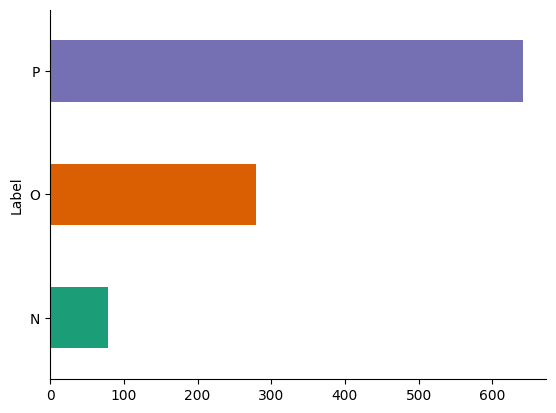

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
fb.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-26-ffba65df7e2e>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fb['comment_length'], bins=50, kde=False)


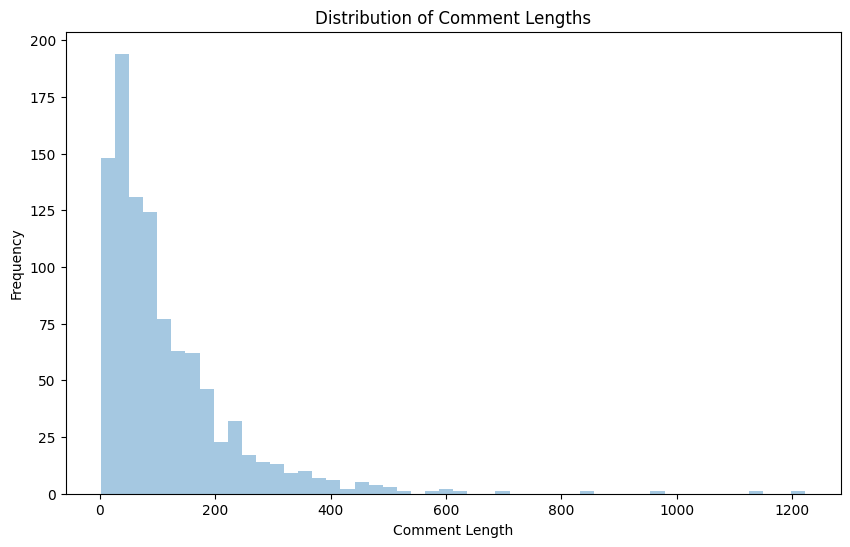

In [ ]:
plt.figure(figsize=(10, 6))
fb['comment_length'] = fb['FBPost'].apply(len)
sns.distplot(fb['comment_length'], bins=50, kde=False)
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths')
plt.show()


Data Preperation


In [ ]:
#lowercasing the text and removing symbols though RegEx
import re
fb['FBPpost'] = fb['FBPost'].apply(lambda x: x.lower())
fb['FBPost'] = fb['FBPost'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
fb = fb[fb.Label != "O"]

In [ ]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(fb['FBPost'].values)
X = tokenizer.texts_to_sequences(fb['FBPost'].values)
X = pad_sequences(X)

In [ ]:
fb.Label.value_counts()

Label
P    641
N     79
Name: count, dtype: int64

In [ ]:
Y = pd.get_dummies(fb['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(482, 203) (482, 2)
(238, 203) (238, 2)


Model

In [ ]:
embed_dim = 200
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 203, 200)          400000    
                                                                 
 spatial_dropout1d (Spatial  (None, 203, 200)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 721202 (2.75 MB)
Trainable params: 721202 (2.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
batch_size = 32
hist = model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
16/16 - 24s - loss: 0.4360 - accuracy: 0.8610 - 24s/epoch - 1s/step
Epoch 2/7
16/16 - 16s - loss: 0.3069 - accuracy: 0.8963 - 16s/epoch - 1s/step
Epoch 3/7
16/16 - 16s - loss: 0.2691 - accuracy: 0.8983 - 16s/epoch - 984ms/step
Epoch 4/7
16/16 - 17s - loss: 0.2137 - accuracy: 0.9087 - 17s/epoch - 1s/step
Epoch 5/7
16/16 - 16s - loss: 0.1343 - accuracy: 0.9585 - 16s/epoch - 974ms/step
Epoch 6/7
16/16 - 16s - loss: 0.0697 - accuracy: 0.9772 - 16s/epoch - 989ms/step
Epoch 7/7
16/16 - 16s - loss: 0.0254 - accuracy: 0.9979 - 16s/epoch - 1s/step


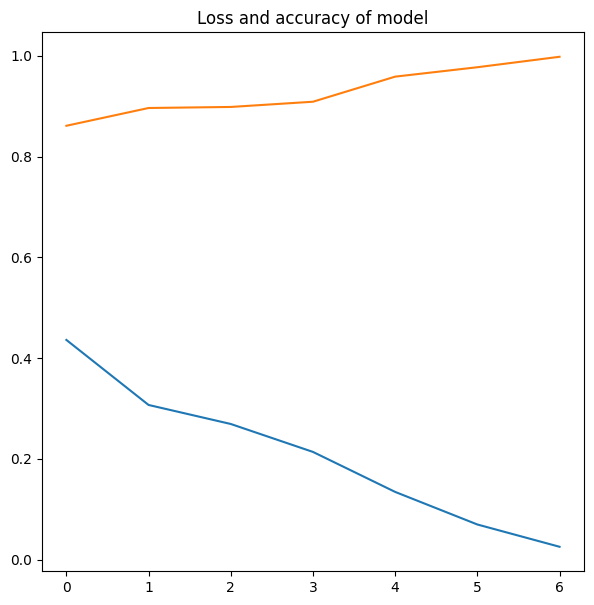

In [ ]:
#Plotting a histogram over the 7 epocs and plotting the accuracy and loss
history = pd.DataFrame(hist.history)
plt.figure(figsize=(7,7));
plt.plot(history["loss"]);
plt.plot(history["accuracy"]);
plt.title("Loss and accuracy of model");
plt.show();

In [ ]:
#Testing the model, and retrieveing score and accuracy:
score,acc = model.evaluate(X_test,Y_test)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

8/8 [==============================] - 3s 246ms/step - loss: 0.4196 - accuracy: 0.8782
score: 0.42
accuracy: 0.88


In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
x_test = X_test[:-validation_size]
y_test = Y_test[:-validation_size]

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    result = model.predict(X_validate[x].reshape(1,x_test.shape[1]),verbose = 2)[0]
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("positive_acc", pos_correct/pos_cnt*100, "%")
print("negative_acc", neg_correct/neg_cnt*100, "%")

1/1 - 1s - 752ms/epoch - 752ms/step
1/1 - 0s - 243ms/epoch - 243ms/step
1/1 - 0s - 246ms/epoch - 246ms/step
1/1 - 0s - 194ms/epoch - 194ms/step
1/1 - 0s - 174ms/epoch - 174ms/step
1/1 - 0s - 152ms/epoch - 152ms/step
1/1 - 0s - 235ms/epoch - 235ms/step
1/1 - 0s - 318ms/epoch - 318ms/step
1/1 - 0s - 361ms/epoch - 361ms/step
1/1 - 0s - 122ms/epoch - 122ms/step
1/1 - 0s - 120ms/epoch - 120ms/step
1/1 - 0s - 126ms/epoch - 126ms/step
1/1 - 0s - 126ms/epoch - 126ms/step
1/1 - 0s - 139ms/epoch - 139ms/step
1/1 - 0s - 120ms/epoch - 120ms/step
1/1 - 0s - 125ms/epoch - 125ms/step
1/1 - 0s - 120ms/epoch - 120ms/step
1/1 - 0s - 125ms/epoch - 125ms/step
1/1 - 0s - 123ms/epoch - 123ms/step
1/1 - 0s - 135ms/epoch - 135ms/step
1/1 - 0s - 124ms/epoch - 124ms/step
1/1 - 0s - 123ms/epoch - 123ms/step
1/1 - 0s - 129ms/epoch - 129ms/step
1/1 - 0s - 123ms/epoch - 123ms/step
1/1 - 0s - 126ms/epoch - 126ms/step
1/1 - 0s - 136ms/epoch - 136ms/step
1/1 - 0s - 122ms/epoch - 122ms/step
1/1 - 0s - 125ms/epoch - 125

In [ ]:
#now testing  on a random sample from the Facebook comments on Kindle's page:
cmnt = ['your customer service is the absolute worst i now have a mess of books on my kindle']
#vectorizing the comment
cmnt = tokenizer.texts_to_sequences(cmnt)
cmnt = pad_sequences(cmnt, maxlen=203, dtype='int32', value=0)
print(cmnt)
sentiment = model.predict(cmnt,batch_size=2,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  51 510 674  12   2 895   1  69  11   6
   13  16  20   3   4]]
1/1 - 0s - 259ms/epoch - 259ms/step
positive
